Loading geo grid...
Transforming cellSize
Transformed cellSize and generated grid translation
loaded geogrid. Time Elapsed: 6.522430419921875 seconds

Subsetting Cost grid...
Subsetting cost grid completed. Time Elapsed: 6.523387670516968 seconds

Loading cost...
loaded cost. Time Elapsed: 102.09206509590149 seconds

Adding graph vertices...
Added Vertices. Time Taken: 11.792845249176025 seconds

Adding graph Edges...
Added Edges. Time Taken: 28.825738668441772 seconds



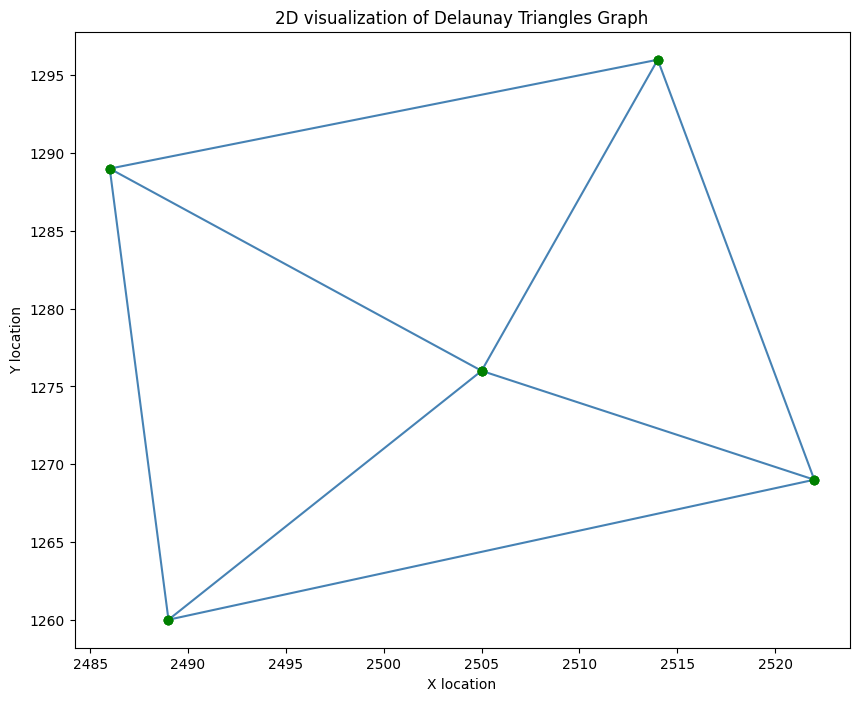

The lengths are:  {(8987224, 8938634): 26.899494936611667, (8938634, 8938630): 4, (8848455, 8799904): 17.899494936611667, (8799904, 8799906): 2, (8737431, 8799904): 34.72792206135786, (8848455, 8938634): 20.384776310850242, (8737431, 8848455): 22.62741699796953, (8737431, 8938630): 30.242640687119287, (8848455, 8987224): 23.72792206135786, (8987224, 8799906): 30.313708498984766}

The weights are:  {(8987224, 8938634): 13.459999999999992, (8938634, 8938630): 1.8, (8848455, 8799904): 9.409999999999998, (8799904, 8799906): 0.9, (8737431, 8799904): 17.369999999999997, (8848455, 8938634): 11.69, (8737431, 8848455): 13.7, (8737431, 8938630): 20.61, (8848455, 8987224): 15.239999999999995, (8987224, 8799906): 19.929999999999993}

The weighted costs are:  {(8987224, 8938634): 13.459999999999992, (8938634, 8938630): 1.8, (8848455, 8799904): 9.409999999999998, (8799904, 8799906): 0.9, (8737431, 8799904): 17.369999999999987, (8848455, 8938634): 11.69, (8737431, 8848455): 13.7, (8737431, 8938630): 

In [1]:
import time
import pandas as pd
import numpy as np
from dummyCostSurface import dummyCostSurface
from networkDelanunay import networkDelanunay
from geotransformation import geoTransformation
from networkx import DiGraph
import networkx as nx
from matplotlib import rcParams
import matplotlib.pyplot as plt
from itertools import combinations
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline
rcParams['figure.figsize'] = 10, 8

class candidateNetwork(DiGraph):
    def __init__(self, width=100, height=100):
        super().__init__()
        self.width = width
        self.height = height
        self.existingPath = {}
        self.existingPathVertices = {}
        self.existingPathType = {}
        self.sources = {}
        self.sinks = {}
        self.spathsCost = {}
        self.spaths = {}
        self.assetsXY = {}
        self.assetsLatLon = {}
        self.assetsPT = {}
        self.assetNameFromPT = {}
        self.assetNameFromXY = {}
        self.initial_pipe_spaths = {}
        self.assetCap = {}
        self.existingPathBounds = {}
        self.spathsLength = {}
        self.spathsWeight = {}
        
        
    
    def initialize_dummy_cost_surface(self):
        C = dummyCostSurface(width=self.width, height=self.height, lowcost=1, highcost=60, ctype='float')
        C.generate_cost_surface()
        
        self.add_nodes_from(C.get_vertices())
        self.add_edges_from(C.get_ebunch())
        
    def initialize_cost_surface(self):
        self.gt = geoTransformation()
        self.gt.processGeoCost()

        self.width = self.gt.getWidth()
        self.height = self.gt.getHeight()

        edges = self.gt.getEdegsDict()

        cellsize = self.gt.getCellSize()


        start_time = time.time()
        print("Adding graph vertices...")
        self.add_nodes_from(self.gt.getVertices())
        print("Added Vertices. Time Taken: %s seconds" %(time.time() - start_time))
        print("")

        # self.add_edges_from(self.gt.getEdgesList())

        start_time = time.time()
        print("Adding graph Edges...")
        for key in edges.keys():
            # print(key[0], key[1], edges[key])
            if (abs(key[0] - key[1]) == self.width+1) or (abs(key[0] - key[1]) == self.width-1):
                approx_l = np.sqrt(2) #km
            else:
                approx_l = cellsize #km
            self.add_edge(key[0], key[1], weight=edges[key], length=approx_l)
        print("Added Edges. Time Taken: %s seconds" %(time.time() - start_time))
        print("")
    
    
    def add_vertices_from_list(self, vertices):
        self.add_nodes_from(vertices)
        
    def add_edges_from_list(self, edgelist):
        self.add_edges_from(edgelist)
        
        
    def import_pipeline(self, input_dir, pathname, flowtype='bidirectional'):
        pipeline = pd.read_excel(input_dir)
        pipe_nodes = []
        start_nodes = pipeline['Start'].values
        end_nodes = pipeline['End'].values
        lower_bound = pipeline['Lower Cap'].values[0]
        upper_bound = pipeline['Upper Cap'].values[0]
        
        for i in range(len(pipeline)):
            pipe_nodes.append((start_nodes[i], end_nodes[i]))
            
        self.add_existing_zero_cost_path(pathname, pipe_nodes, flowtype)
        self.existingPathType[pathname] = flowtype
        self.existingPathBounds[pathname] = [lower_bound, upper_bound]


    def import_pipeline_lat_long(self, input_dir, flowtype='bidirectional'):
        pipeline = pd.read_excel(input_dir)
        pipe_nodes = []
        start_nodes = []
        end_nodes = []
        
        pathname = pipeline["Name"][0]
        lower_bound = pipeline['Lower Cap'].values[0]
        upper_bound = pipeline['Upper Cap'].values[0]
        
        for i in range(len(pipeline)):
            cell = self.gt._latlonToCell(pipeline["Lat"][i], pipeline["Long"][i])
            if i == 0:
                start_nodes.append(cell)
            elif i == len(pipeline)-1:
                end_nodes.append(cell)
            else:
                start_nodes.append(cell)
                end_nodes.append(cell)
    
        for i in range(len(start_nodes)):
            if start_nodes[i] != end_nodes[i]:
                pipe_nodes.append((start_nodes[i], end_nodes[i]))


        edges = [edge for edge in self.edges]
        pipe_nodes_mod = []
        for nodepair in pipe_nodes:
            if nodepair in edges:
                pipe_nodes_mod.append(nodepair)
            else:
                start_list = []
                end_list = []
                s_p = nx.shortest_path(self, nodepair[0], nodepair[1], weight='weight')
                for i in range(len(s_p)):
                    if i == 0:
                        start_list.append(s_p[i])
                    elif i == len(s_p) - 1:
                        end_list.append(s_p[i])
                    else:
                        start_list.append(s_p[i])
                        end_list.append(s_p[i])
                
                for i in range(len(start_list)):
                    pipe_nodes_mod.append((start_list[i], end_list[i]))

        
        self.add_existing_zero_cost_path(pathname, pipe_nodes_mod, flowtype)
        self.existingPathType[pathname] = flowtype
        self.existingPathBounds[pathname] = [lower_bound, upper_bound]

        

        

        
    def add_existing_zero_cost_path(self, pathname, path_nodes, flowtype):
        existingPathVertices = {}
        np = 0
        edges = [edge for edge in self.edges]
        for nodepair in path_nodes:
            # self.edges[nodepair[0], nodepair[1]]['weight'] = 0
            if flowtype == 'bidirectional':
                if (nodepair[0], nodepair[1]) in edges:
                    self.edges[nodepair[0], nodepair[1]]['weight'] = 0
                else:
                    self.add_edge(nodepair[0], nodepair[1], weight=0)

                if (nodepair[1], nodepair[0]) in edges:
                    self.edges[nodepair[1], nodepair[0]]['weight'] = 0
                else:
                    self.add_edge(nodepair[1], nodepair[0], weight=0)
            elif flowtype == 'unidirectional':
                if (nodepair[0], nodepair[1]) in edges:
                    self.edges[nodepair[0], nodepair[1]]['weight'] = 0
                else:
                    self.add_edge(nodepair[0], nodepair[1], weight=0)

                if (nodepair[1], nodepair[0]) in edges:
                    self.edges[nodepair[1], nodepair[0]]['weight'] = 1e9
                else:
                    self.add_edge(nodepair[1], nodepair[0], weight=1e9)
            
            if pathname in self.existingPath:
                self.existingPath[pathname].append(nodepair)
            else:
                self.existingPath[pathname] = [nodepair]
            
            if pathname in existingPathVertices:
                existingPathVertices[pathname].append(nodepair[0])
            else:
                existingPathVertices[pathname] = [nodepair[0]]
                
            np = nodepair[1]
        
        existingPathVertices[pathname].append(np)
        self.existingPathVertices = existingPathVertices
        
    def get_existing_zero_cost_path(self):
        return self.existingPath
    
    def get_existing_zero_cost_path_vertices(self):
        return self.existingPathVertices
    
    def get_initial_pipe_spaths(self):
        return self.initial_pipe_spaths
    
    def enforce_pipeline_tie_point(self, pathname, point1=None, point2=None, exclusion=False, etype='before'):
        #convert x,y to points on the graph
        if point1:
            point1 = self.gt._xyToCell(point1[0], point1[1])
        if point2:
            point2 = self.gt._xyToCell(point2[0], point2[1])
        
        
        #case 1: 2 tie in points with all exclusion
        if point1 and point2 and (not exclusion):
            for edge in self.edges:
                #in
                if (edge[1] in self.existingPathVertices[pathname]) and (edge[0] not in self.existingPathVertices[pathname]) \
                    and (edge[1] != point1) and (edge[1] != point2):
                    self.edges[edge]['weight'] = 1e9
                    
                #out
                if (edge[0] in self.existingPathVertices[pathname]) and (edge[1] not in self.existingPathVertices[pathname]) \
                    and (edge[0] != point1) and (edge[0] != point2):
                    self.edges[edge]['weight'] = 1e9
                
            
        #case 2: 2 tie in points with exclusion at ends
        elif point1 and point2 and exclusion:
            #get all the vertices before and after point 1 and 2
            pathvertices = self.existingPathVertices[pathname].copy()
            minidx, maxidx = map(pathvertices.index, (point1, point2))
            minidx, maxidx = min(minidx, maxidx), max(minidx, maxidx)
            not_excluded = pathvertices[minidx:maxidx+1]
            exclusion_list = [i for i in pathvertices if i not in not_excluded]
            
            for edge in self.edges:
                #in
                if (edge[1] in exclusion_list) and (edge[0] not in pathvertices) \
                    and (edge[1] != point1) and (edge[1] != point2):
                    self.edges[edge]['weight'] = 1e9
                
                #out
                if (edge[0] in exclusion_list) and (edge[1] not in pathvertices) \
                    and (edge[0] != point1) and (edge[0] != point2):
                    self.edges[edge]['weight'] = 1e9
                    
        
        else:
            #case 3 single point with all exclusion but source/sink
            if (point1 or point2) and (not exclusion):
                point = point1 or point2
                pathvertices = self.existingPathVertices[pathname].copy()
                if pathvertices[0] > pathvertices[-1]: #make the path always read from left to right
                    pathvertices.reverse()
                if etype == 'before':
                    exclusion_list = pathvertices[:-1] #means source/sink is at end of path
                else:
                    exclusion_list = pathvertices[1:] #means source/sink is at begining of path
                
                for edge in self.edges:
                    #in
                    if (edge[1] in exclusion_list) and (edge[0] not in pathvertices) \
                        and (edge[1] != point):
                        self.edges[edge]['weight'] = 1e9
                    #out    
                    if (edge[0] in exclusion_list) and (edge[1] not in pathvertices) \
                        and (edge[0] != point):
                        self.edges[edge]['weight'] = 1e9
                
            
            #case 4 single point with before or after exclusion on one end
            elif (point1 or point2) and exclusion:
                point = point1 or point2
                pathvertices = self.existingPathVertices[pathname].copy()
                if pathvertices[0] > pathvertices[-1]: #make the path always read from left to right
                    pathvertices.reverse()
                if etype == 'before':
                    exclusion_list = pathvertices[:pathvertices.index(point)]
                else:
                    exclusion_list = pathvertices[pathvertices.index(point)+1:]
                    
                for edge in self.edges:
                    #in
                    if (edge[1] in exclusion_list) and (edge[0] not in pathvertices) \
                        and (edge[1] != point):
                        self.edges[edge]['weight'] = 1e9
                    
                    #out
                    if (edge[0] in exclusion_list) and (edge[1] not in pathvertices) \
                        and (edge[0] != point):
                        self.edges[edge]['weight'] = 1e9
                

    
    def enforce_no_pipeline_diagonal_Xover(self):
        edges = [edge for edge in self.edges]

        for pathname in self.existingPath.keys():
            for nodepair in self.existingPath[pathname]:
                if abs(nodepair[0] - nodepair[1]) == self.width+2:
                    lower_diag = min(nodepair) + 1
                    upper_diag = max(nodepair) - 1
                    
                    if (lower_diag, upper_diag) in edges:
                        self.edges[(lower_diag, upper_diag)]['weight'] = 1e9
                    if (upper_diag, lower_diag) in edges:
                        self.edges[(upper_diag, lower_diag)]['weight'] = 1e9
                    
                elif abs(nodepair[0] - nodepair[1]) == self.width:
                    lower_diag = min(nodepair) - 1
                    upper_diag = max(nodepair) + 1
                    
                    if (lower_diag, upper_diag) in edges:
                        self.edges[(lower_diag, upper_diag)]['weight'] = 1e9
                    if (upper_diag, lower_diag) in edges:
                        self.edges[(upper_diag, lower_diag)]['weight'] = 1e9
        return
    
    def enforce_no_path_diagonal_Xover(self, path_tup):
        edges = [edge for edge in self.edges]

        for nodepair in path_tup:
            if abs(nodepair[0] - nodepair[1]) == self.width+2:
                lower_diag = min(nodepair) + 1
                upper_diag = max(nodepair) - 1
                    
                if (lower_diag, upper_diag) in edges:
                    self.edges[(lower_diag, upper_diag)]['weight'] = 1e9
                if (upper_diag, lower_diag) in edges:
                    self.edges[(upper_diag, lower_diag)]['weight'] = 1e9
                    
            elif abs(nodepair[0] - nodepair[1]) == self.width:
                lower_diag = min(nodepair) - 1
                upper_diag = max(nodepair) + 1
                    
                if (lower_diag, upper_diag) in edges:
                    self.edges[(lower_diag, upper_diag)]['weight'] = 1e9
                if (upper_diag, lower_diag) in edges:
                    self.edges[(upper_diag, lower_diag)]['weight'] = 1e9
        return
    
    
    def add_sources(self, sourcelist):
        for source in sourcelist:
            self.sources[source[0]] = [source[1], source[2]]
            self.assetsLatLon[source[0]] = [source[1], source[2]]
            xy = self.gt._latlonToXY(source[1], source[2])
            self.assetsXY[source[0]] = [xy[0], xy[1]]
            self.assetCap[source[0]] = source[3]
            
    def add_sinks(self, sinklist):
        for sink in sinklist:
            self.sinks[sink[0]] = [sink[1], sink[2]]
            self.assetsLatLon[sink[0]] = [sink[1], sink[2]]
            xy = self.gt._latlonToXY(sink[1], sink[2])
            self.assetsXY[sink[0]] = [xy[0], xy[1]]
            self.assetCap[sink[0]] = -sink[3]
            
    def _generate_assetsPT(self):
        for key in self.assetsXY.keys():
            self.assetsPT[key] = self.gt._xyToCell(self.assetsXY[key][0], self.assetsXY[key][1])
            
        for key in self.assetsPT.keys():
            self.assetNameFromPT[self.assetsPT[key]] = key
            
        for key in self.assetsXY.keys():
            self.assetNameFromXY[(self.assetsXY[key][0], self.assetsXY[key][1])] = key
            
    
    
    def generateDelaunayNetwork(self):
        self.D = networkDelanunay(width=self.width-1, height=self.height-1)
        assets = []
        for key, asset in self.assetsXY.items():
            assets.append(asset)
            
        assets = np.array(assets)
        self.D.add_points_from_list(assets)
        self.D.createDelaunayNetwork()

        
    def showDelaunayNetwork(self):
        self.D.plotNetwork()    
            
    def add_Delaunay_tiepoints(self, tieptslist):
        for tiepts in tieptslist:
            if tiepts[0] in self.sources.keys():
                node1 = self.sources[tiepts[0]]
            elif tiepts[0] in self.sinks.keys():
                node1 = self.sinks[tiepts[0]]
                
            if tiepts[2] in self.sources.keys():
                node2 = self.sources[tiepts[2]]
            elif tiepts[2] in self.sinks.keys():
                node2 = self.sinks[tiepts[2]]
            
            self.assetsXY[f"Tnode from {tiepts[0]} to pipeline1"] = tiepts[1]
            self.assetsXY[f"Tnode from {tiepts[2]} to pipeline1"] = tiepts[3]
            
                
            self.D.add_tie_in_point(node1,tiepts[1])
            self.D.add_tie_in_point(node2, tiepts[3])
            self.D.add_tie_in_point(tiepts[1], tiepts[3])
            self.D.delete_line_path(node1, node2)
            
            self.enforce_pipeline_tie_point(tiepts[4], tiepts[1], tiepts[3])
            
        return
    
    def get_sources(self):
        return self.sources
    
    def get_sinks(self):
        return self.sinks
        
    def print_edges(self):
        for edge in self.edges:
            print(edge, self.edges[edge])
                
    def weight_func(self, distance, time):
        return distance * time
    
    def get_shortest_path_and_length(self, source, destination):
        # slength = nx.shortest_path_length(self, source, destination, weight=lambda u, v, d: self.weight_func(d['weight'], d['length']))
        # spath = nx.shortest_path(self, source, destination, weight=lambda u, v, d: self.weight_func(d['weight'], d['length']))
        slength = nx.shortest_path_length(self, source, destination, weight='weight')
        spath = nx.shortest_path(self, source, destination, weight='weight')
        return slength, spath
    
    def get_all_source_sink_shortest_paths(self):
        lines = self.D.getDelaunayNetwork()
        for line in lines:
            cost, path = self.get_shortest_path_and_length(line[0], line[1])
            self.spathsCost[(line[0], line[1])] = cost
            self.spaths[(line[0], line[1])] = path
            self.initial_pipe_spaths[(line[0], line[1])] = path
            
            path_tup = [(path[i], path[i+1]) for i in range(len(path)-1)]
            self.enforce_no_path_diagonal_Xover(path_tup)
        
        self._generate_assetsPT()
            
    def get_spathsCost(self):
        return self.spathsCost
    
    def print_candidate_shortest_paths(self):
        print("The lengths are: ", self.spathsLength)
        print("")
        print("The weights are: ", self.spathsWeight)
        print("")
        print("The weighted costs are: ", self.spathsCost)
        print("")
        print("The shortest paths are: ", self.spaths)
        print("")
        print(len(self.spathsCost), len(self.spaths))
        
    def print_assets(self):
        print(self.assetsPT)
        print(self.assetsXY)
        print(len(self.assetsPT), len(self.assetsXY))
    
    def show_candidate_network(self):
        rcParams['figure.figsize'] = 20, 20
        
        # ptslist = self.nodes
        ptslist = self.edges
        
        self._generate_assetsPT()
        
        
        #plot the shortest paths between nodes
        for key in self.spaths.keys():
            xs = []
            ys = []
            for pt in self.spaths[key]:
                xy = self.gt._cellToXY(pt)
                xs.append(xy[0])
                ys.append(xy[1])
            plt.plot(xs, ys, label=f"path between {self.assetNameFromPT[key[0]]} and {self.assetNameFromPT[key[1]]}", lw = 5)
        
        #plot all existing pipelines
        for key in self.existingPathVertices.keys():
            xp = []
            yp = []
            for pt in self.existingPathVertices[key]:
                xy = self.gt._cellToXY(pt)
                xp.append(xy[0])
                yp.append(xy[1])
            plt.plot(xp, yp, 'red', lw=6, alpha=0.5)
        
        #plot the gridcelll
        # xss = []
        # yss = []
        # for pt in list(ptslist):
        #     xys = self.gt._cellToXY(pt)
        #     xss.append(xys[0])
        #     yss.append(xys[1])

        # plt.plot(xss, yss, 'o', color='green', mew=0.000000001, alpha=0.1)


        # xss = []
        # yss = []
        # for edge in list(ptslist):
        #     for pt in edge:
        #         xys = self.gt._cellToXY(pt)
        #         xss.append(xys[0])
        #         yss.append(xys[1])

        # plt.plot(xss, yss, 'o', color='green', mew=0.000000001, alpha=0.1)
        
        
        #plot asset markers
        for key in self.assetsXY.keys():
            x = self.assetsXY[key][0]
            y = self.assetsXY[key][1]
            if "node" in key:
                plt.plot(x,y, marker='o', mfc='orange', ms=5, mec='black')
            elif "source" in key:
                plt.plot(x,y, marker="s", mfc='black', ms=5, mec='black')
                plt.plot(x,y, marker=f"${key}$", mfc='black', ms=40, mec='black')
            elif "sink" in key:
                plt.plot(x,y, marker="s", mfc='yellow', ms=5, mec='red')
                plt.plot(x,y, marker=f"${key}$", mfc='yellow', ms=30, mec='red')
        
        plt.title("Candidate CO2 Sequestration Network")
        plt.xlabel("X location")
        plt.ylabel("Y location")
#         plt.legend()
        plt.show()
        
        return
    
    def extract_network(self):
        return
    
    def get_pipe_trans_nodes(self):
        existingPathVertices = self.existingPathVertices.copy()       
        spaths = self.spaths.copy()
        
        trans_nodes = {}
        conn_to_del = []
        for pathname in existingPathVertices.keys():
            for nodepair in spaths.keys():
                entry = False
                start = self.spaths[nodepair][0]
                end = self.spaths[nodepair][-1]
                for i in range(len(spaths[nodepair])):
                    if (entry == False) and (spaths[nodepair][i] in existingPathVertices[pathname]):
                        entry = True
                        trans_nodes[(pathname, nodepair)] = [spaths[nodepair][i]]
                    if (entry == True) and (spaths[nodepair][i] not in existingPathVertices[pathname]):
                        trans_nodes[(pathname, nodepair)].append(spaths[nodepair][i-1])
                        break
                
                if (entry == True) and (len(trans_nodes[(pathname, nodepair)]) == 1):
                    trans_nodes[(pathname, nodepair)].append(spaths[nodepair][-1])
                
                if entry == True:
                    node1 = trans_nodes[(pathname, nodepair)][0]
                    node2 = trans_nodes[(pathname, nodepair)][1]
                    idx1 = spaths[nodepair].index(node1)
                    idx2 = spaths[nodepair].index(node2)
                    
                    self._generate_assetsPT()
                                    
 
                    self.spaths[(node1, node2)] = self.spaths[nodepair][idx1:idx2+1]
                    self.spaths[(start, node1)] = self.spaths[nodepair][0:idx1+1]
                    self.spaths[(node2, end)] = self.spaths[nodepair][idx2:]
                    
                    
                    cost_1 = 0
                    cost_2 = 0
                    for i in range(len(self.spaths[(start, node1)])-1):
                        cost_1 += self.edges[self.spaths[(start, node1)][i], self.spaths[(start, node1)][i+1]]['weight']
                    for i in range(len(self.spaths[(node2, end)])-1):
                        cost_2 += self.edges[self.spaths[(node2, end)][i], self.spaths[((node2, end))][i+1]]['weight']
                    
                    
                    self.spathsCost[(node1, node2)] = 0
                    self.spathsCost[(start, node1)] = cost_1
                    self.spathsCost[(node2, end)] = cost_2
                    
                    
                    
                    from_name = self.assetNameFromPT[nodepair[0]]
                    to_name = self.assetNameFromPT[nodepair[1]]
                    
                    self.assetsXY[pathname + f" from {from_name} to {to_name} node1"] = self.gt._cellToXY(node1)
                    self.assetsXY[pathname + f" from {from_name} to {to_name} node2"] = self.gt._cellToXY(node2)
                    
                    conn_to_del.append((start, end))
        
        for conn in conn_to_del:            
            del self.spaths[conn]
            del self.spathsCost[conn]
                        
                        
        return
                
        
    def pipe_post_process(self):
        self._generate_assetsPT() 
        
        for pathname in self.existingPath.keys():
            nodes_on_pipe = []
            for key in self.assetNameFromPT.keys():
                if key in self.existingPathVertices[pathname]:
                    nodes_on_pipe.append((key, self.existingPathVertices[pathname].index(key)))
            nodes_on_pipe = list(set(nodes_on_pipe))
            nodes_on_pipe.sort(key=lambda x: x[1])
            nodes_on_pipe = [i for (i, j) in nodes_on_pipe]
            
            list_combinations = list()
            
            for n in range(len(nodes_on_pipe)+1):
                list_combinations += list((combinations(nodes_on_pipe, n)))
                
            list_combinations = [tup for tup in list_combinations if len(tup) == 2]
            
            joints = [(nodes_on_pipe[i], nodes_on_pipe[i+1]) for i in range(len(nodes_on_pipe)-1)]
            edges_to_remove = [tup for tup in list_combinations if tup not in joints]
            
            #remove redundant edges
            for edge in edges_to_remove:
                if edge in self.spaths.keys():
                    del self.spaths[edge]
                if edge in self.spathsCost.keys():
                    del self.spathsCost[edge]
            
            
            #add edges with cost
            for edge in joints:
                slength, spath = self.get_shortest_path_and_length(edge[0], edge[1])
                self.spaths[edge] = spath
                self.spathsCost[edge] = slength
                
        self._generate_assetsPT()
            
            
    def _print_assetNameFromPT(self):
        print(self.assetNameFromPT)
        print(len(self.assetNameFromPT))
    
    def get_trans_nodes(self):
        self._generate_assetsPT()   
        spaths = self.spaths.copy()

        trans_nodes = {}
        conn_to_del = []
        
        for pathname in spaths.keys():
            for nodepair in spaths.keys():
                entry = False
                start = spaths[nodepair][0]
                end = spaths[nodepair][-1]

                for i in range(len(spaths[nodepair])):
                    if (entry == False) and (spaths[nodepair][i] in spaths[pathname]):
                        entry = True
                        trans_nodes[(pathname, nodepair)] = [spaths[nodepair][i]]
                    if (entry == True) and (spaths[nodepair][i] not in spaths[pathname]):
                        trans_nodes[(pathname, nodepair)].append(spaths[nodepair][i-1])
                        break
                
                
                if entry == True:
                    if len(trans_nodes[(pathname, nodepair)]) == 1:
                        trans_nodes[(pathname, nodepair)].append(spaths[nodepair][-1])
                    
                    if trans_nodes[(pathname, nodepair)][0] == trans_nodes[(pathname, nodepair)][1]:
                        pass
                    else:
                        node1 = trans_nodes[(pathname, nodepair)][0]
                        node2 = trans_nodes[(pathname, nodepair)][1]
                        idx1 = spaths[nodepair].index(node1)
                        idx2 = spaths[nodepair].index(node2)

                        
                        self._generate_assetsPT()
                

                        if start != node1:
                            self.spaths[(start, node1)] = self.spaths[nodepair][0:idx1+1]
                            cost_1 = 0
                            for i in range(len(self.spaths[(start, node1)])-1):
                                cost_1 += \
                                self.edges[self.spaths[(start, node1)][i], self.spaths[(start, node1)][i+1]]['weight']
                            self.spathsCost[(start, node1)] = cost_1
                        
                        if node1 != node2:
                            self.spaths[(node1, node2)] = self.spaths[nodepair][idx1:idx2+1]
                            cost_2 = 0
                            for i in range(len(self.spaths[(node1, node2)])-1):
                                cost_2 += \
                                self.edges[self.spaths[(node1, node2)][i], self.spaths[((node1, node2))][i+1]]['weight']
                            self.spathsCost[(node1, node2)] = cost_2
                        
                        if node2 != end:
                            self.spaths[(node2, end)] = self.spaths[nodepair][idx2:]
                            cost_3 = 0
                            for i in range(len(self.spaths[(node2, end)])-1):
                                cost_3 += \
                                self.edges[self.spaths[(node2, end)][i], self.spaths[((node2, end))][i+1]]['weight']
                            self.spathsCost[(node2, end)] = cost_3
                        
                        from_name = self.assetNameFromPT[nodepair[0]]
                        to_name = self.assetNameFromPT[nodepair[1]]
                        
                            
                        if node1 in self.assetNameFromPT.keys():
                            if ('sink' not in self.assetNameFromPT[node1]) \
                                and ('source' not in self.assetNameFromPT[node1]):
                                self.assetsXY[str(pathname) + f" from {from_name} to {to_name} node1"] = \
                                self.gt._cellToXY(node1)
                        else:
                            self.assetsXY[str(pathname) + f" from {from_name} to {to_name} node1"] = \
                            self.gt._cellToXY(node1)
                        
                        if node2 in self.assetNameFromPT.keys():
                            if ('sink' not in self.assetNameFromPT[node2]) \
                                and ('source' not in self.assetNameFromPT[node2]):
                                self.assetsXY[str(pathname) + f" from {from_name} to {to_name} node2"] = \
                                self.gt._cellToXY(node2)   
                        else:
                            self.assetsXY[str(pathname) + f" from {from_name} to {to_name} node2"] = \
                            self.gt._cellToXY(node2)

                        conn_to_del.append((start, end))
#                         self._generate_assetsPT()
        
        for conn in list(set(conn_to_del)):            
            del self.spaths[conn]
            del self.spathsCost[conn]
                        
                        
        return
    
    def trans_node_post_process(self):
        self._generate_assetsPT() 
        
        for pathname in self.initial_pipe_spaths.keys():
            nodes_on_pipe = []
            for key in self.assetNameFromPT.keys():
                if key in self.initial_pipe_spaths[pathname]:
                    nodes_on_pipe.append((key, self.initial_pipe_spaths[pathname].index(key)))
            nodes_on_pipe = list(set(nodes_on_pipe))
            nodes_on_pipe.sort(key=lambda x: x[1])
            nodes_on_pipe = [i for (i, j) in nodes_on_pipe]
            
            list_combinations = list()
            
            for n in range(len(nodes_on_pipe)+1):
                list_combinations += list((combinations(nodes_on_pipe, n)))
                
            list_combinations = [tup for tup in list_combinations if len(tup) == 2]
            
            joints = [(nodes_on_pipe[i], nodes_on_pipe[i+1]) for i in range(len(nodes_on_pipe)-1)]
            edges_to_remove = [tup for tup in list_combinations if tup not in joints]
            
            #remove redundant edges
            for edge in edges_to_remove:
                if edge in self.spaths.keys():
                    del self.spaths[edge]
                if edge in self.spathsCost.keys():
                    del self.spathsCost[edge]
            
            
            #add edges with cost
            for edge in joints:
                slength, spath = self.get_shortest_path_and_length(edge[0], edge[1])
                self.spaths[edge] = spath
                self.spathsCost[edge] = slength
                
        self._generate_assetsPT()
        
    def plot_extracted_graph(self):
        res = []
        for key in self.spathsCost.keys():
            pt1 = self.gt._cellToXY(key[0])
            pt2 = self.gt._cellToXY(key[1])
            res.append((pt1, pt2))
            
        for line in res:
            x = []
            y = []
            x.append(line[0][0])
            y.append(line[0][1])
            x.append(line[1][0])
            y.append(line[1][1])
            plt.plot(x, y,  marker='o', mfc='green', mec='green', label=f"from {line[0]} to {line[1]}")
        
        plt.title('2D visualization of extracted Graph')
        plt.xlabel("X location")
        plt.ylabel('Y location')
        # plt.legend()
        plt.show()
        
    def shortest_paths_post_process(self):
        spaths = self.spaths.copy()
        spathsCost = self.spathsCost.copy()
        
        for key in self.spaths.keys():
            if ((key[0], key[1]) in spaths.keys()) and ((key[1], key[0]) in spaths.keys()):
                del spaths[(key[1], key[0])]
                del spathsCost[(key[1], key[0])]
                
        self.spaths = spaths.copy()
        self.spathsCost = spathsCost.copy()

        for key in spaths.keys():
            t_length = 0
            t_weight = 0
            for i in range(len(spaths[key]) - 1):
                nodelist = spaths[key]
                t_weight += self.edges[(nodelist[i], nodelist[i+1])]['weight']
                t_length += self.edges[(nodelist[i], nodelist[i+1])]['length']
            self.spathsWeight[key] = t_weight
            self.spathsLength[key] = t_length

    def _getMappingData(self):
        assets_df = {"Name": [],
                "Lat": [],
                "Lon": [],
                "Type": []}

        for key in self.assetsXY.keys():
            x = self.assetsXY[key][0]
            y = self.assetsXY[key][1]
            lat, lon = self.gt._xyToLatLon(x, y)
            assets_df["Name"].append(key)
            assets_df["Lat"].append(lat)
            assets_df["Lon"].append(lon)
            if "node" in key:
                assets_df["Type"].append("node")
            elif "source" in key:
                assets_df["Type"].append("source")
            elif "sink" in key:
                assets_df["Type"].append("sink")


        self.assets_df = pd.DataFrame(assets_df)

        pipelines_df = {"Name": [],
                        "Lat": [],
                        "Lon": []}

        for key in self.spaths.keys():
            for pt in self.spaths[key]:
                lat, lon = self.gt._cellToLatLon(pt)
                pipelines_df["Name"].append(key)
                pipelines_df["Lat"].append(lat)
                pipelines_df["Lon"].append(lon)

        self.pipelines_df = pd.DataFrame(pipelines_df)

        self.unique_pipes = self.pipelines_df["Name"].unique()

        self.lines = self.D.getDelaunayNetwork()


    def _getDelaunayMapFig(self):
        assets_subset = self.assets_df[self.assets_df["Type"] in ["source", "sink"]]
        fig1 = px.scatter_mapbox(assets_subset, lat="Lat", lon="Lon", hover_name="Name", color="Type", zoom=8, height=1000, width=1000, size="Lat", 
                                color_discrete_map={"source":"red", "sink":"green"})
        fig1.update_layout(mapbox_style="open-street-map")


        for line in self.lines:
            lat1, lon1 = self.gt._cellToLatLon(line[0])
            lat2, lon2 = self.gt._cellToLatLon(line[1])
            fig1.add_trace(go.Scattermapbox(
                mode = "lines",
                lat = [lat1, lat2],
                lon = [lon1, lon2],
                showlegend=False
                
            ))

        return fig1

    def _getAlternateNetworkMapFig(self):
        fig2 = px.scatter_mapbox(self.assets_df, lat="Lat", lon="Lon", hover_name="Name", color="Type", zoom=8, height=1000, width=1000, size="Lat", 
                                color_discrete_map={"source":"red", "sink":"green",  "node":"orange"})
        fig2.update_layout(mapbox_style="open-street-map")

        for pipe in self.unique_pipes: 
            fig2.add_trace(go.Scattermapbox(
                mode = "lines",
                lat = self.pipelines_df[self.pipelines_df.Name == pipe]["Lat"],
                lon = self.pipelines_df[self.pipelines_df.Name == pipe]["Lon"],
                showlegend=False
                
            ))  

        return fig2

    def _getSolnNetworkMapFig(self, soln_arcs):              
        fig3 = px.scatter_mapbox(self.assets_df, lat="Lat", lon="Lon", hover_name="Name", color="Type", zoom=8, height=1000, width=1000, size="Lat", 
                                color_discrete_map={"source":"red", "sink":"green",  "node":"orange"})
        fig3.update_layout(mapbox_style="open-street-map")

        for pipe in self.unique_pipes: 
            fig3.add_trace(go.Scattermapbox(
                mode = "lines",
                lat = self.pipelines_df[self.pipelines_df.Name == pipe]["Lat"],
                lon = self.pipelines_df[self.pipelines_df.Name == pipe]["Lon"],
                showlegend=False
            
                
            ))

        for pipe in self.unique_pipes:
            if pipe in soln_arcs.keys(): 
                fig3.add_trace(go.Scattermapbox(
                    mode = "lines",
                    lat = self.pipelines_df[self.pipelines_df.Name == pipe]["Lat"],
                    lon = self.pipelines_df[self.pipelines_df.Name == pipe]["Lon"],
                    showlegend=False, 
                    opacity=0.5,
                    line={'width': 10, 'color':'green'}
                    
                ))    

        return fig3

        
    def export_network(self):
        nodesdict = {}
        nodenames = []
        idx = 1
        pipe_idx = 1
        for key,value in self.assetNameFromPT.items():
            for pipeline in self.existingPath.keys():
                if pipeline in value:
                    nodesdict[key] = f'{pipeline}_TS'+str(pipe_idx)
                    nodenames.append(f'{pipeline}_TS'+str(pipe_idx))
                    pipe_idx+=1
                    break           
            if ('from' in value) and (key not in nodesdict.keys()):
                nodesdict[key] = 'TS'+str(idx)
                nodenames.append('TS'+str(idx))
                idx+=1
            elif key not in nodesdict.keys():
                nodesdict[key] = value
                nodenames.append(value)
                
        # print("nodesdict: ", nodesdict)
        arcsCost = {}
        arcsLength = {}
        arcsWeight = {}
        arcsPath = {}
        arcs = []
        
        
        for key, value in self.spathsCost.items():
            node1 = nodesdict[key[0]]
            node2 = nodesdict[key[1]]
            arcsCost[(node1, node2)] = value
            arcsCost[(node2, node1)] = value
            arcsLength[(node1, node2)] = self.spathsLength[key]
            arcsLength[(node2, node1)] = self.spathsLength[key]
            arcsWeight[(node1, node2)] = self.spathsWeight[key]
            arcsWeight[(node2, node1)] = self.spathsWeight[key]
            arcsPath[(node1, node2)] = self.spaths[key]
            arcsPath[(node2, node1)] = [i for i in reversed(self.spaths[key])]
            arcs.append((node1, node2))
            arcs.append((node2, node1))
        
        #get b values for network graph
        nodes_b ={key:0 for key in nodenames}

        for node in nodes_b:
            if node in self.assetCap.keys():
                nodes_b[node] = self.assetCap[node]

        #define all arc info [length, weight, w_cost, lower_bound, upper_bound]
        arcsInfo = {key:[arcsLength[key],arcsWeight[key],arcsCost[key], 0, 1e9] for key in arcsCost.keys()}

        for arc in arcs:
            arc_1 = arc[0].split("_")[0]
            arc_2 = arc[1].split("_")[0]
            if arc_1 == arc_2:
                if arc_1 in self.existingPathBounds.keys():
                    arcsInfo[arc][3] = self.existingPathBounds[arc_1][0]
                    arcsInfo[arc][4] = self.existingPathBounds[arc_1][1]
        
        



        return nodenames, arcs, arcsInfo, arcsPath, nodes_b
        
        
        

        
if __name__ == '__main__':
    
    
    start = time.time() #start timer

    #Build graph  
    g = candidateNetwork()
    # gt = geoTransformation()
    # gt._loadgeogrid()
    # gt._loadcost()
    # g.initialize_dummy_cost_surface()
    g.initialize_cost_surface()

    # g.print_edges()
    

    
    
#     #Import existing pipeline
#     g.import_pipeline(input_dir=r'C:\Users\david\CO2 TRANSPORT NETWORK MODEL\Existing Pipeline.xlsx', pathname='pipeline1')
    g.import_pipeline_lat_long(input_dir=r"C:\Users\david\CO2 TRANSPORT NETWORK MODEL\coffeyville pipeline.xlsx")
    
    # #confirm pipeline has been imported
    # print(g.get_existing_zero_cost_path())
    # print(g.get_existing_zero_cost_path_vertices())
    
   
#     #g.print_edges()
    
    
    #Enter source and sink locations:
    #source: (sourceName, lat, lon, AnnualCO2Cap)
    #sink: (sinkName, lat, lon, TotalCO2Cap)
    sources = [('source 1', 35.88223702516557, -97.11222429425534, 1), 
                ('source 2', 36.13905202726716, -97.05651000483053, 2), 
                ('source 3', 36.026137827693354, -96.89024145409819, 1)]
    sinks = [('sink 1', 35.95805451963144, -96.72419771977717, 20), 
                ('sink 2', 36.205883132892225, -96.72282142615266, 15)]
    
    g.add_sources(sources)
    g.add_sinks(sinks)
    
    #Generate Delaunay network
    g.generateDelaunayNetwork()
    
# #     #Modify Delaunay network if required and add tiepoints from source to xy of pipeline
# #     tiepts = [['source 1', [30, 7], 'sink 1', [66,12], 'pipeline1']]
# #     g.add_Delaunay_tiepoints(tiepts)
    
    #show Delaunay network
    g.showDelaunayNetwork()

#     # #enforce pipeline tie in points
#     # pipetiept1 = (30, 7)
#     # pipetiept2 = (66, 12)
#     # g.enforce_pipeline_tie_point('pipeline1', pipetiept1, pipetiept2, exclusion=False, etype='before')
    
    #enforce no diagonal crossover for existing pipelines
    g.enforce_no_pipeline_diagonal_Xover()
    
    #Genrate abd show candidate network
    g.get_all_source_sink_shortest_paths()
    g.get_trans_nodes()
    g.trans_node_post_process()
    g.get_pipe_trans_nodes()
    g.pipe_post_process()
    g.shortest_paths_post_process()
    g._getMappingData()
    # g.show_candidate_network()
    # g.plot_extracted_graph()
    fig1 = g._getDelaunayMapFig()
    fig1.show()
    fig2 = g._getAlternateNetworkMapFig()
    fig2.show()
    g.print_candidate_shortest_paths()
    
    
# #     g.get_pipe_trans_nodes()
    
#     # g._print_assetNameFromPT()
    
#     nodes, arcs, costs, paths, b = g.export_network()
    
#     print(nodes)
#     print(" ")
#     # print(arcs)
#     print(" ")
#     print(costs)
#     print(" ")
#     # print(paths)
#     print(" ")
#     print(b)
    
#     end = time.time() #end timer
    
#     #show time elapse
#     print("Total Time Elapsed: ", end - start)
#     print("")


In [5]:
def _getMappingData(self):
    assets_df = {"Name": [],
             "Lat": [],
             "Lon": [],
             "Type": []}

    for key in self.assetsXY.keys():
        x = self.assetsXY[key][0]
        y = self.assetsXY[key][1]
        lat, lon = self.gt._xyToLatLon(x, y)
        assets_df["Name"].append(key)
        assets_df["Lat"].append(lat)
        assets_df["Lon"].append(lon)
        if "node" in key:
            assets_df["Type"].append("node")
        elif "source" in key:
            assets_df["Type"].append("source")
        elif "sink" in key:
            assets_df["Type"].append("sink")


    self.assets_df = pd.DataFrame(assets_df)

    pipelines_df = {"Name": [],
                    "Lat": [],
                    "Lon": []}

    for key in self.spaths.keys():
        for pt in self.spaths[key]:
            lat, lon = self.gt._cellToLatLon(pt)
            pipelines_df["Name"].append(key)
            pipelines_df["Lat"].append(lat)
            pipelines_df["Lon"].append(lon)

    self.pipelines_df = pd.DataFrame(pipelines_df)

    self.unique_pipes = pipelines_df["Name"].unique()

    self.lines = self.D.getDelaunayNetwork()


def _getDelaunayMapFig(self):
    fig1 = px.scatter_mapbox(self.assets_df, lat="Lat", lon="Lon", hover_name="Name", color="Type", zoom=8, height=1000, width=1000, size="Lat", 
                            color_discrete_map={"source":"red", "sink":"green",  "node":"orange"})
    fig1.update_layout(mapbox_style="open-street-map")


    for line in self.lines:
        lat1, lon1 = self.gt._cellToLatLon(line[0])
        lat2, lon2 = self.gt._cellToLatLon(line[1])
        fig1.add_trace(go.Scattermapbox(
            mode = "lines",
            lat = [lat1, lat2],
            lon = [lon1, lon2],
            showlegend=False
            
        ))

    return fig1

def _getAlternateNetworkMapFig(self):
    fig2 = px.scatter_mapbox(self.assets_df, lat="Lat", lon="Lon", hover_name="Name", color="Type", zoom=8, height=1000, width=1000, size="Lat", 
                            color_discrete_map={"source":"red", "sink":"green",  "node":"orange"})
    fig2.update_layout(mapbox_style="open-street-map")

    for pipe in self.unique_pipes: 
        fig2.add_trace(go.Scattermapbox(
            mode = "lines",
            lat = self.pipelines_df[self.pipelines_df.Name == pipe]["Lat"],
            lon = self.pipelines_df[self.pipelines_df.Name == pipe]["Lon"],
            showlegend=False
            
        ))  

    return fig2


In [23]:

assets_df = {"Name": [],
             "Lat": [],
             "Lon": [],
             "Type": []}

for key in g.assetsXY.keys():
    x = g.assetsXY[key][0]
    y = g.assetsXY[key][1]
    lat, lon = g.gt._xyToLatLon(x, y)
    assets_df["Name"].append(key)
    assets_df["Lat"].append(lat)
    assets_df["Lon"].append(lon)
    if "node" in key:
        assets_df["Type"].append("node")
    elif "source" in key:
        assets_df["Type"].append("source")
    elif "sink" in key:
        assets_df["Type"].append("sink")



assets_df = pd.DataFrame(assets_df)

pipelines_df = {"Name": [],
                "Lat": [],
                "Lon": []}

for key in g.spaths.keys():
    for pt in g.spaths[key]:
        lat, lon = g.gt._cellToLatLon(pt)
        pipelines_df["Name"].append(key)
        pipelines_df["Lat"].append(lat)
        pipelines_df["Lon"].append(lon)

pipelines_df = pd.DataFrame(pipelines_df)

unique_pipes = pipelines_df["Name"].unique()



lines = g.D.getDelaunayNetwork()
lines




fig1 = px.scatter_mapbox(assets_df, lat="Lat", lon="Lon", hover_name="Name", color="Type", zoom=8, height=1000, width=1000, size="Lat", 
                            color_discrete_map={"source":"red", "sink":"green",  "node":"orange"})
fig1.update_layout(mapbox_style="open-street-map")


for line in lines:
    lat1, lon1 = g.gt._cellToLatLon(line[0])
    lat2, lon2 = g.gt._cellToLatLon(line[1])
    fig1.add_trace(go.Scattermapbox(
        mode = "lines",
        lat = [lat1, lat2],
        lon = [lon1, lon2],
        showlegend=False
        
    ))

fig1.show()


fig2 = px.scatter_mapbox(assets_df, lat="Lat", lon="Lon", hover_name="Name", color="Type", zoom=8, height=1000, width=1000, size="Lat", 
                            color_discrete_map={"source":"red", "sink":"green",  "node":"orange"})
fig2.update_layout(mapbox_style="open-street-map")

for pipe in unique_pipes: 
    fig2.add_trace(go.Scattermapbox(
        mode = "lines",
        lat = pipelines_df[pipelines_df.Name == pipe]["Lat"],
        lon = pipelines_df[pipelines_df.Name == pipe]["Lon"],
        showlegend=False
        
    ))  

fig2.show()


In [19]:
pipelines_df[pipelines_df.Name == unique_pipes[0]]["Lat"].iloc[[0,-1]]

0     36.204438
24    36.141354
Name: Lat, dtype: float64

In [4]:
# gridWidth = 6938
# gridHeight = 2983
# gridVertices = [i for i in range(1, ((gridWidth*gridWidth) + 1))]
# gridcost = {}


# def initializeCostgrid():
#     for i in gridVertices:
#         neighbors = getNeighbors(i)
#         print(neighbors)
#         # for neighbor in neighbors:
#         #     if neighbor != 0:
#         #         gridcost[(i, neighbor)] = 1e6

# def getNeighbors(cell):
#     neighbors = [cell+1, cell-1, cell + gridWidth, cell - gridWidth, cell + gridWidth + 1, 
#                 cell + gridWidth - 1, cell - gridWidth + 1, cell - gridWidth - 1]
#     for i in range(len(neighbors)):
#         if (neighbors[i] < 0) or (neighbors[i] > gridHeight * gridWidth):
#             neighbors[i] = 0
#     return neighbors
            

# initializeCostgrid()

In [18]:
#extract 2 way arcs
a_a = {(8,7), (1,2), (3,4), (5,6), (2,1), (4,3), (6,5), (7,8)}
seen = {}
result = []

for (a, b) in a_a:
    print(a,b)
    if (a, b) not in seen:
        seen[(a,b)] = True
        print(seen)
        if (b, a) in seen:
            print(a,b, "*")
            result.append((b,a))

set(result)

1 2
{(1, 2): True}
2 1
{(1, 2): True, (2, 1): True}
2 1 *
3 4
{(1, 2): True, (2, 1): True, (3, 4): True}
4 3
{(1, 2): True, (2, 1): True, (3, 4): True, (4, 3): True}
4 3 *
8 7
{(1, 2): True, (2, 1): True, (3, 4): True, (4, 3): True, (8, 7): True}
6 5
{(1, 2): True, (2, 1): True, (3, 4): True, (4, 3): True, (8, 7): True, (6, 5): True}
5 6
{(1, 2): True, (2, 1): True, (3, 4): True, (4, 3): True, (8, 7): True, (6, 5): True, (5, 6): True}
5 6 *
7 8
{(1, 2): True, (2, 1): True, (3, 4): True, (4, 3): True, (8, 7): True, (6, 5): True, (5, 6): True, (7, 8): True}
7 8 *


{(1, 2), (3, 4), (6, 5), (8, 7)}